# Tarea 1 Grupo 24

###### Francisco Paez
###### Catalina Blanco
###### Diego Di Battista



En el siguiente informe analizaremos dos problemas relacionados con la pandemia de COVID-19 que, en la actualidad, azota a todo el mundo, enfocándonos en nuestros algoritmos para obtener las soluciones y en el por qué usamos cada parte del algoritmo.
El primer problema trata del modelo de contagio del virus, en el cual usamos bases de datos de distintos tamaños con instancias de individuos y las reuniones interpersonales en las que interactuaban cada día, y para las probabilidades de contagio de cada persona en ellas. En el problema simulamos la escalabilidad de los contagios, dados los parámetros de probabilidad de contagio y las instancias dadas de reuniones entre personas. También ilustramos graficamente curvas cumulativas tanto de contagios, recuperados y enfermos para cada día de la simulación. Seguido de eso, analizamos la eficiencia de nuestro algoritmo y lo pusimos a prueba haciendo un número de simulaciones para así obtener probabilidades frecuentistas de contagio, usando distintos datos en cada una (cambiando la semilla de simulación).

El segundo problema habla del abastecimiento y distribución provocado por las restricciones interpersonales que se han impuesto para poder frenar este virus. **(ACÁ FALTA DESCRIBIR EL SEGUNDO PROBLEMA, LO HAGO DESPUÉS)**

En la primera parte del informe, hablaremos del primer problema, del contagio, donde explicaremos los archivos secundarios del código, con sus funciones y estructuras de datos, y después pasaremos al archivo principal, en el que mostrareros mostraremos las librerías utilizadas, analizaremos la complejidad del algoritmo y resultados obtenidos a partir de lo requerido en el enunciado.


# Parte 1 

## Archivos secundarios


En primer lugar se nos fue entregada la funcion **simulation_parameters()** que nos entregará la cantidad de días que tienen que pasar para que una persona que se enfermó con el virus, vuelva a estar completamente sana. También nos dice los días que demora en darse cuenta que está infectada, es decir, la cantidad de días que es vector de contagio y no lo sabe, por lo que sigue teniendo reuniones con otras personas, pudiendo infectarlas. Por último, nos entrega **contagios** que es una especie de dado para poder trabajar como variable aleatoria la probabilidad de contagio de cada persona en cada día.
Nosotros como grupo, creemos que esta función es un tanto ineficiente, ya que nos da un nuevo número de probabilidad de contagio para cada persona cada día, aun cuando estas personas podrían no tener una reunión aquella jornada, por lo que nos da datos inútiles. Sin embargo, no es un problema para el código dado que lo tuvimos en cuenta en el orden y tampoco es un problema en términos de memoria por el tamaño de las instancias.

In [1]:
from random import seed, random
from numpy.random import poisson, negative_binomial
from numpy.random import seed as npseed



def simulation_parameters(total, delta_t,s):
    seed(s)
    npseed(s)
    r_p = {i: poisson(15) for i in range(total)} # El tiempo de recuperacion
    c_p = {i: min(r_p[i], negative_binomial(6,0.5)) for i in range(total)} # Tiempo en que se da cuenta
    contagios = {t: {i: random() for i in range(total)} for t in range(delta_t + 1)}

    return r_p, c_p, contagios
### es ineficiente, porque nos da el numero de probabilidad de que se contagie en cada día aunque no se reunan (son numeros inuyiles)
## que no es tan importante, pero lo tuvimos en cuenta para el orden

Creamos la clase ```Persona```, que toma como parámetros el *id* de la persona, es decir, el número para identificarla, y su probabilidad de contagio dada en la base de datos de las personas. Como atributos de esta clase hicimos el atributo *id*, que está dado por su parámetro homónimo, también hicimos el atributo **.\_probabilidad_contagio** que al igual que *id* solamente viene dado por el parámetro. Creamos los atributos estado, días de recuperacón y días de síntoma para ```Persona```.
* **Estado:** describe el estado de salud de cada persona. Inicia siempre con *S* que significa que todos comienzan sanos, pero pueden haber cambios de estado debido a los contagios y avances del virus en cada persona, tema que se explicará más adelante. 
* **Días de recuperación (.\_dias_recuperacion):** es una cuenta regresiva que representa cuántos días quedan para que el infectado vuelva a estar sano. Inicia siempre en 0, debido a que, como dijimos antes, todos comienzan sanos. Vale decir que este atributo cambia de valor cuando se contagia. 
* **Días de síntomas (.\_dias_sintomas):** también es una cuenta regresiva que al igual que la anterior se inicializa en 0 por la misma razón y solo se cambia el valor cuando la persona se infecta. Sin embargo, esta representa los días restantes para que la persona comience a presentar síntomas, es decir, que no solamente sea un vector de contagio, sino que pase a ser debidamente un infectado (y en la situación comience a restarse de las reuniones).

A continuación se definen las propiedades de la clase ```Persona```, las cuales manejan los cambios de estado de cada persona, es decir, son funciones que van cambiando automáticamente las condiciones de cada atributo de ```Persona```. Modifican la situación de cada instancia persona dadas las condiciones, como por ejemplo desde _S_, que significa que esta sano a _A_ , que sería que este con el virus y esté asintomático, es decir que sea un vector, que luego pase a _E_ que nos dice que ahora sí presenta sintomas, o sea que está enfermo, y que pasen los días y pase a tener como estado _R_ o _M_ que significaría que esta recuperado o muerto respectivamente. Como grupo, agregamos el estado muerto para darle realidad al problema, ya que se está obviando una posibilidad muy real y no debería pasarse por alto.

En esto se evidencia la ventaja de usar Programación Orientada a Objetos (Clases), en que son moldeables, es muy fácil de cambiar estados, clasificarlos y de agregar todo tipo de información de manera ordenada, a diferencia de otras estructuras de datos que son inmutables o más complicadas de acceder a datos, como las tuplas y las listas respectivamente. Además, el uso de memoria de la clase es pequeño, ya que al ser 5 atributos por persona, su memoria es O(5 × _n_), siendo _n_ el número de personas.

Luego creamos dos metodos, **contacto** y **pasar_dia**. El primero, se usa para cuando una persona sana se enfrenta a un posible contagio, como tener contacto con otra persona que es vector de contagio, y consiste en una especie de tirar el dado para crear una variable aleatoria , dejando la posibilidad de contagio como un evento azaroso. En el caso de que sí se contagie, se actualiza el estado de esa persona y las cuentas regresivas se ajustan según sus propios días de recuperacion y días hasta que tenga síntomas. El segundo método de pasar día, solamente se ejecuta en personas que estén enfermas o asintomáticas y no con las sanas o muertas con el fin de no correr la función de manera innecesaria. Y lo que hace es simplemente pasar un día, es decir actualizar las cuentas regresivas que tenga, como si hubiera pasado un día.


In [2]:
class Persona:
    def __init__(self,id,probabilidad_contagio):
        self._id = id 
        self._probabilidad_contagio = probabilidad_contagio #probabilidad de contagio inicial de cada persona
        self.estado = "S" # S: sano; A asintomatico; E enfermo ; M muerto ; R recuperado
        self._dias_recuperacion = 0 #cuenta regresiva a recuperacion, se inicializan en 0 porque al principio no saben si tienen la enfermedad
        self._dias_sintomas = 0 #cuenta regresiva a presentar sintomas
    @property
    def dias_recuperacion(self):  # manejan los cambios de estado (todas las propertys @)
        return self._dias_recuperacion
    @dias_recuperacion.setter
    def dias_recuperacion(self, a):
        if(a <= 0):
            self._dias_recuperacion = 0
            self.estado = "R"
        self._dias_recuperacion = a
    @property
    def dias_sintomas(self):
        return self._dias_sintomas
    @dias_sintomas.setter
    def dias_sintomas(self, a):    #dias hasta que empiezan a tener sintomas
        if(a <= 0):
            self._dias_sintomas = 0
            self.estado = "E"                    #usamos clases por facilidad de modificar y clasificar estados, agregar todo tipo de informacion
        self._dias_sintomas = a
    def contacto(self,dado,dias_recuperacion,dias_sintomas):        #dado es para ver si se contagio o no, dado el numero del dado
        if self.estado == "S" and dado <= self._probabilidad_contagio:
            self.estado = "A"
            self._dias_recuperacion = dias_recuperacion
            self._dias_sintomas = min(dias_sintomas, dias_recuperacion)

    def pasar_dia (self):
        if self.estado in ["A","E"]:                 #solo afecta si estas asintomatico o enfermo, sino estas sano o muerto, no afecta
            if self.estado == "A":
                self.dias_sintomas -= 1
            self.dias_recuperacion -= 1

    def __repr__(self):                     #los dos para que se vea bonito
        return self.estado+str(self._id)
    def __str__(self):
        if self.estado == "S":
            return f"Soy {self._id}, estoy Sano, P contagio {self._probabilidad_contagio}"
        if self.estado == "A":
            return f"Soy {self._id}, estoy Asintomatico,sintomas:{self._dias_sintomas}, recuperacion {self._dias_recuperacion}"
        if self.estado == "E":
            return f"Soy {self._id}, estoy Enfermo, recuperacion {self._dias_recuperacion}"
        if self.estado == "R":
            return f"Soy {self._id}, estoy Recuperado "

Se nos pide crear la funcion **graficar_infectados** a la cual le entregamos un diccionario con los números de contagiados en cada día y los números de recuperados e infectados hasta la fecha. Nos retorna un gráfico con las curvas que generaron estos datos por día y también guarda este gráfico como un archivo *.png*.

In [3]:
#Codigo_Graficos.py
import matplotlib.pyplot as plt
import numpy as np


def graficar_infectados(diccionario):
    cantidad_casos_totales = diccionario["it"]   #it es infectados totales
    cantidad_casos_recuperados = diccionario["r"] #recueprados
    cantidad_casos_actuales = diccionario["i"] #infectados actuales
    x = diccionario["t"]   # dia
    plt.plot(x, cantidad_casos_actuales,label= 'casos actuales')
    plt.plot(x, cantidad_casos_recuperados, label= 'casos recuperados')
    plt.plot(x, cantidad_casos_totales, label= 'casos totales')
    plt.ylabel('Cantidad de infectados')
    plt.xlabel('Días')
    plt.title("Infectados en función del tiempo")

    plt.legend(loc=0)
    plt.savefig("grafico_infectados.png")
    mostrar=plt.show()
    return mostrar

# Main script 
## Librerias Y VERBOSIDAD


En cuanto a las librerías, las comentadas no son necesarias en jupyter notebook porque ya se ejecutaron las celdas.
Si verboso es ```True``` se imprimirán cosas en la consola, sino no se irán imprimiendo las simulaciones.

In [4]:
from collections import defaultdict          #para ordenarse en los momentos de reunion
#from personas import Persona                #clase creada, mencionada en la celda anterior
#from simulation_parameters import simulation_parameters    #para llamar a la funcion simulation_parameters
#from Codigo_Graficos import graficar_infectados            #para llamar a la funcion
import os  #https://stackoverflow.com/questions/7165749/open-file-in-a-relative-location-in-python
import re  #https://stackoverflow.com/questions/1249388/removing-all-non-numeric-characters-from-string-in-python
import copy  #https://www.geeksforgeeks.org/copy-python-deep-copy-shallow-copy/
import time  #medir los tiempos tiempos de simulacion, para medir la eficienci
VERBOSIDAD = 1 # 0 es no imprimir nada, 1 minimo (recomendado), 2 es imprimir lo basico  , 3 es imprimir los detalles

Para poder modelar la evolución temporal del contagio en la red, tuvimos que crear un grafo organizándolo de la siguiente manera: 
* El conjunto de nodos iba a corresponder a cada persona cada día, siendo un nodo la persona 1 el día 1, otro nodo esa misma persona el día 2, puesto que sus parámetros cambiaban y sus relaciones dependían del espacio temporal en el cual se ubicaba (las reuniones se hacían un día especifico). 
* El conjunto de los arcos iba a corresponder a las reuniones entre las personas en cada día: Cada persona se unía con si misma al día siguiente, de manera dirigida, porque el arco dirigido en las reuniones tiene un significado de sentido en la enfermedad, es decir, si la persona 1 tiene el virus y la 2 no, es 1 quien contagia a 2, y no al revés. Además, en el eje del tiempo es más intuitivo el por qué de la dirección del arco, pero este fin radica en ordenar la evolución temporal de la enfermedad y que no se pueda mirar de forma alguna tal que alguien que estaba enfermo el día 2 contagió a una persona el día 1. 


En fin, se puede ver gráficamente esto como un plano cartesiano donde las coordenadas de cada nodo son *(t,n)* donde *t* es el día y *n* el id de la persona. Los arcos unen a las personas que se juntaron ese día. El arco temporal une *(t,n)* con *(t+1,n)* .

Modelar los arcos de esta forma, nos lleva a ahorrar mucho en términos de memoria en el código, ya que almacenamos las reuniones de manera más eficiente. 

Tomemos el ejemplo de que se juntan las personas 1, 2 y 3 el día 1, entonces si se uniera cada persona presente en la reunión entre sí, ocuparíamos 6 arcos en describir esa reunión: *((1,1),(1,2)),((1,1),(1,3)),((1,2),(1,1)),((1,2),(1,3)),((1,3),(1,1)),((1,3),(1,2))*. En cambio, si lo almacenamos en sets, tiene una memoria constante y el set sería solamente ((1,1),(1,2),(1,3)), lo que sería comparar un almacenamiento de orden O(n!) con uno de orden O(n × t), respectivamente.

En el código implementamos, tal como nos pedían, la función **crear_grafo** a la que le damos los archivos de las reuniones y de las personas y nos retorna el conjunto de nodos y de arcos, es decir, nos retorna el grafo.

In [5]:
#archivo main.py
def crear_grafo ( personas, reuniones):
    """ Crea un default diccionario donde las llaves son los dias y los elementos son una
    lista con los sets con los id de las personas que se juntaron """
    data_reuniones = defaultdict(list)
    with open (reuniones) as file:    
        linea = file.__next__()       
    inter = linea.split("({")         #lee la base de datos

    for i in range(1,len(inter)):
        parcial = set(map(int,inter[i].split("}")[0].split(", ")))    #usamos sets porque es mas eficiente la busqueda, facilita todo
        dia = int(re.sub("[^0-9]", "",inter[i].split("}")[1] ))       
        data_reuniones[dia].append(parcial)
    #reuniones son los arcos
    #cantidad de dia desde la infeccion que su estado de Enfermos con Sintomas
    """ Crea un diccionario donde las llaves son las id y los elementos son instancias de la clase personas"""
    data_personas = dict()    #no es defaultdict porque no tiene sentido preguntar por personas que no existen (gigo)
    with open (personas) as file:   #fue un diccionario en vez de una lista, porque al principio estaba  desordenado y ahora no, pero ya esta hecho
        linea = file.__next__().strip("{}")
    inter = linea.split(", ")
    for i in inter:
        persona = i.split(":")
        id = int(persona[0])
        data_personas[id]= Persona(id,float(persona[1]))   #aca se guardo en cada nodo, una instancia para cada persona
    return (data_personas,data_reuniones)

# aca va el codigo de la funcion
script_dir = os.path.dirname("Informe.ipynb") #<-- absolute dir the script is in
CODIGO = 1500 #Cantidad de pacientes
personas = os.path.join(script_dir, f"Instancias/personas_{CODIGO}.txt")     #aca se crea el grafo (incluyendo las siguientes 3 lineas)
reuniones = os.path.join(script_dir, f"Instancias/reuniones_{CODIGO}.txt")
grafo = crear_grafo(personas,reuniones)  

En esta sección implementamos la función **determinar_contagiados** que recibe nuestro gráfico hecho con la función **crear_grafo**, el *id* del primer infectado, y el número de días transcurridos. Esta función trabaja usando sets que tiene como elementos a las personas posiblemente contagiadas. Usa métodos de los sets como **.add** , **.union**,los cuales tienen una complejidad de O(Log n), y **.intersection** que tiene un orden de complejidad de O(n), además de buscar dentro del mismo set, que tiene O(1); por lo que la función es de orden lineal, lo que la hace bastante eficiente.

El caso que causaría más ineficiencia en la función (y en cualquier otra función del código) es el caso en el que todas las personas se juntaran todos los días sin descanso, ya que elevaría muchísimo la cantidad de memoria y el tiempo de ejecución del programa aletarandolo definitivamente.

In [6]:
#archivo main.py

#bastante efciciente creo que el peor caso seria si todas las personas se juntaran todos los dias
def determinar_contagiados(grafo, p0 ,delta_dias):
    #grafo es un grafo formado por la estructura de la funcion crear_grafo
    #p0 es in integer con el indice del paciente 0
    #delta_dias número de días transcurridos
    posibles = set()
    posibles.add(p0)
    data_reuniones = grafo[1]
    for t in range (0,delta_dias+1):
        if VERBOSIDAD>1:
            print(f"POSIBLES al principio del DIA {t}",posibles)
        for reunion in data_reuniones[t]:
            if posibles.intersection(reunion):
                posibles = posibles.union(reunion)
                if VERBOSIDAD > 3:
                    print(F"Reunion infectada DIA{t}:",reunion, "culpables:",posibles.intersection(reunion))
    if VERBOSIDAD > 1:
        print(F"\n POSIBLES al final del dia {t}",posibles)
    return posibles

#acá se debería correr la función
script_dir = os.path.dirname("Informe.ipynb") #<-- absolute dir the script is in
CODIGO = 1500 #Cantidad de pacientes
personas = os.path.join(script_dir, f"Instancias/personas_{CODIGO}.txt")     #aca se crea el grafo (incluyendo las siguientes 3 lineas)
reuniones = os.path.join(script_dir, f"Instancias/reuniones_{CODIGO}.txt")
grafo = crear_grafo(personas,reuniones)
p0 = 33 #paciente original
delta_dias = 7 # Cantidad de dias
determinar_contagiados(grafo,p0,delta_dias)

{0,
 5,
 9,
 11,
 14,
 20,
 22,
 24,
 25,
 26,
 27,
 29,
 32,
 33,
 34,
 35,
 37,
 45,
 48,
 49,
 50,
 51,
 54,
 56,
 58,
 60,
 64,
 65,
 69,
 71,
 72,
 73,
 77,
 78,
 80,
 83,
 84,
 86,
 89,
 92,
 95,
 96,
 98,
 100,
 102,
 106,
 108,
 109,
 115,
 118,
 121,
 130,
 131,
 133,
 134,
 142,
 147,
 148,
 157,
 158,
 160,
 161,
 163,
 166,
 168,
 169,
 173,
 174,
 175,
 178,
 184,
 187,
 188,
 189,
 193,
 194,
 195,
 196,
 199,
 202,
 203,
 204,
 208,
 213,
 215,
 219,
 228,
 229,
 231,
 232,
 236,
 239,
 241,
 243,
 246,
 250,
 253,
 256,
 257,
 258,
 260,
 264,
 266,
 268,
 272,
 273,
 275,
 276,
 277,
 278,
 283,
 285,
 286,
 288,
 290,
 293,
 296,
 300,
 301,
 302,
 303,
 304,
 307,
 308,
 313,
 318,
 326,
 329,
 331,
 335,
 336,
 340,
 344,
 345,
 346,
 347,
 348,
 350,
 353,
 356,
 362,
 365,
 368,
 369,
 371,
 372,
 374,
 375,
 378,
 379,
 387,
 390,
 391,
 392,
 395,
 396,
 397,
 400,
 404,
 405,
 406,
 410,
 411,
 412,
 414,
 421,
 422,
 425,
 426,
 427,
 428,
 431,
 433,
 434,
 4

Ahora se nos pide simular los contagios desde el paciente cero (primer enfermo) de dos instancias del problema, pero para ello debemos crear la función **simular_contagio**, la cual recibe el grafo hecho en la parte anterior, el id del paciente cero, el número de días que transcurren en la simulación y la semilla de simulación. En esta usamos la función dada al inicio **simulation_parameters** para tener los parámetros de cada ```Persona```, y utilizando nuevamente sets para los asintomáticos o vectores, para los infectados y para los recuperados, en los cuales vamos agregando a los que entran en ese estado cada día y sacando los que se cambian de estado. La razón por la que utilizamos sets es que tienen una complejidad sumamente baja el revisarlos. De sus métodos el más ineficiente que se usa es **.intersection** que tiene una complejidad de O(len(set)), como hemos mencionado anteriormente.

Es en esta función donde está la verdadera fuente de ineficiencia del código, porque tiene que revisar a todas las personas, con sus atributos, todos los días, lo cual tiene una complejidad de O(n × t). Se podría llevar la cuenta de cambios de estado de cada persona con sumas y restas, y así tener también los estados de cada persona a cada momento, pero así perderíamos la moldeabilidad que nos da la POO, la posibilidad de escalar y proyectar el problema y de poder añadir características y más realidad al problema, tales como relaciones más complejas. Por ejemplo, que dos personas vivan en la misma casa, que hayan más enfermedades, que exista la probabilidad de muerte del infectado, entre muchas otras opciones de escalabilidad en una situación real. Todo eso se puede gracias a estamos tratando un objeto, en vez de una sola variable que podria ser un estado asociado a un número, como por ejemplo *S = 0*. Sin embargo, esta función sigue siendo la fuente de ineficiencia del código, por lo que en el caso de que se quisiera mejorar su eficiencia, es esta la sección que se debe trabajar.

En la simulación, el programa nos va entregando la cantidad de infectados ("Inf:"), la cantidad de vectores ("-Vect:") y el número de personas recuperadas ("-Rec:") por cada día de simulación y los datos de cada día se van guardando en listas, para que queden ordenados cronológicamente, luego se itera en cada reunión y se ejecuta la probabilidad de contagio (como mencionamos antes, similar a tirar un dado, con respecto al número de probabilidad asignado a esa persona). Luego, según el estado de cada persona se va agregando a un set para ir mostrando a medida que avanza la simulación y se crean diccionarios a partir de las listas creadas, para que sirvan de parámetros a la función **graficar_infectados**.

Luego, se procede a realizar las dos simulaciones que se piden en el enunciado, una para las instancias dadas en *personas_15000.txt* y *reuniones_15000.txt* y otra para las instancias dadas en *personas_1500.txt* y *reuniones_1500.txt* donde se simula la situación con la función recién descrita y luego se grafican las curvas cumulativas de contagios, de recuperados y de infectados a cada día, con la función también descrita anteriormente, **graficar_infectados**.


Fin del DIA 75
Inf: 0 -Vect: 0 -Rec: 1425


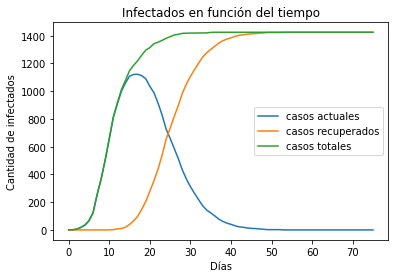

In [7]:
def simular_contagio( grafo, p0, delta_dias, s):
    #vectores = infectados actuales 
    data_personas = grafo[0]           # primer elemento del grafo (los nodos)
    data_reuniones = grafo[1]          # segundo
    "Se simulan los parametros necesarios para cada persona"
    parametros = simulation_parameters(len(data_personas),delta_dias,s)
    dias_recuperacion = parametros[0]
    dias_sintomas = parametros[1]
    contagios = parametros[2]
    vectores = set()        #los que pueden contagiar
    vectores.add(p0)
    infectados = set()
    infectados.add(p0)
    recuperados = set()

    data_personas[p0].contacto(0,dias_recuperacion[p0] , dias_sintomas[p0])  ##inicilizar el tiempo para p0 con sus contadores
    datos_infectados = []
    datos_recuperados = []
    datos_it = []
    dias = []

    for t in range (0,delta_dias+1):
        if VERBOSIDAD > 1:
            print(f"Comienza DIA {t}")
            print("Inf:",len(infectados),"-Vect:",len(vectores),"-Rec:",len(recuperados))
        datos_infectados.append(len(infectados))
        datos_recuperados.append(len(recuperados))
        datos_it.append(len(recuperados)+len(infectados))     #guardando los datos de cada dia para ponerlos en el grafico
        dias.append(t)
        for reunion in data_reuniones[t]:
            culpables = vectores.intersection(reunion) #son los que infectaron la reunion, que tiene complejidad O(len(reunion))
            if culpables:                             #si es que existen culpables, que es lo mismo que decir len(culpables)>0            
                for posible_contagiado in reunion - culpables:       # sacamos los elementos iguales
                    id = posible_contagiado
                    if id not in recuperados and id not in infectados:   # si no esta en ninguno de los dos, esta sano
                        data_personas[id].contacto(contagios[t][id],dias_recuperacion[id] , dias_sintomas[id])  # ese contagios da el numero del dado
       
        ##########################################################
        ##### VERDADERA FUENTE DE INEFICIENCIA DEL PROGRAMA ######
        ##########################################################
        # porque iteramos sobre todas las personas todos los dias O(n*t)   n:cantidad personas, t: cantidad de días
        # si queremos mejorar la eficiencia del codigo, esto es lo que hay que mejorar
        infectados = set()
        vectores = set()
        recuperados = set()
        for i in range(0,len(data_personas)):                   
            data_personas[i].pasar_dia()
            if data_personas[i].estado == "A":
                vectores.add(i)
                infectados.add(i)
            elif data_personas[i].estado == "E":
                infectados.add(i)
            elif data_personas[i].estado == "R":
                recuperados.add(i)
            elif data_personas[i].estado == "S":
                pass
            else:
                print("ERROR ESTADO ANOMALO")
    if VERBOSIDAD:
        print(f"Fin del DIA {t}")
        print("Inf:",len(infectados),"-Vect:",len(vectores),"-Rec:",len(recuperados))
    return infectados,recuperados,{"t":dias,
            "i":datos_infectados,
            "it":datos_it,
            "r":datos_recuperados}


VERBOSIDAD = 1
script_dir = os.path.dirname("Informe.ipynb") #<-- absolute dir the script is in
CODIGO = 1500 #Cantidad de pacientes
personas = os.path.join(script_dir, f"Instancias/personas_{CODIGO}.txt")     #aca se crea el grafo (incluyendo las siguientes 3 lineas)
reuniones = os.path.join(script_dir, f"Instancias/reuniones_{CODIGO}.txt")
grafo = crear_grafo(personas,reuniones)
p0 = 33 #paciente original
delta_dias = 75 # Cantidad de dias
SEED = 6
resultados = simular_contagio( grafo, 33, delta_dias, SEED)
graficar_infectados(resultados[2])

Fin del DIA 68
Inf: 0 -Vect: 0 -Rec: 14190


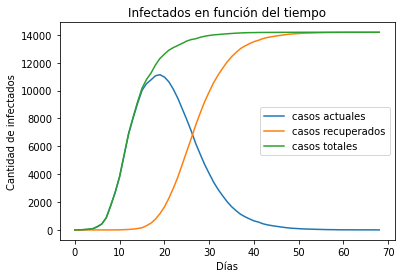

In [8]:
VERBOSIDAD = 1
script_dir = os.path.dirname("Informe.ipynb") #<-- absolute dir the script is in
CODIGO = 15000 #Cantidad de pacientes
personas = os.path.join(script_dir, f"Instancias/personas_{CODIGO}.txt")     #aca se crea el grafo (incluyendo las siguientes 3 lineas)
reuniones = os.path.join(script_dir, f"Instancias/reuniones_{CODIGO}.txt")
grafo = crear_grafo(personas,reuniones)
p0 = 33 #paciente original
delta_dias = 68 # Cantidad de dias
SEED = 1113 
resultados = simular_contagio( grafo, 33, delta_dias, SEED)
graficar_infectados(resultados[2])

*Dato: pusimos esa semilla, los dias y el paciente cero a nuestro gusto, se pueden cambiar y probar*

*Para el análisis usamos p0=33 y seed=1113*

Tomando el caso de las instancias 15000 (*personas_15000.txt* y *reuniones_15000.txt*), podemos ver que hay un crecimiento exponencial durante los primeros 15 días (se puede ir haciendo zoom cambiando la cantidad de días en la celda de arriba), y a partir del día 13 aproximadamente, el crecimiento explosivo de infectados actuales empieza a caer, sigue creciendo, pero no de la misma forma, hasta el día 18 aproximadamente que se da el punto crítico, que es el día en el cual hay más casos(11.1140 enfermos y 3706 vectores). Después de ese día la curva de infectados comienza a decrecer de manera abrupta hasta el día 32 aproximadamente, en el que la curva acumulada de infectados tiene pendiente muy pequeña y la curva de recuperados empieza a aplanarse, quedando 2453 infectados y 294 vectores a esa fecha. Finalmente se da por pasada la pandemia al día 68 en el cual ya no quedan ni infectados ni vectores, ya toda la gente que se enfermó debido al virus esta recuperada.

De lo anterior podemos concluir que no se tomaron las medidas correctas para frenar el contagio o "aplanar la curva", ya que tuvo un pico muy alto y se calmó relativamente rápido. En cambio, en la situación real, el crecimiento ha sido mucho más plano. Aún en Chile se está en la etapa de aumento de casos diarios, por lo que no se ha llegado al punto crítico. Si este caso simulado, se diera en la vida real, los hospitales habrían colapsado hace muchos días y esto sería mucho más caótico de lo que está siendo ahora.



Por último, en esta parte de la tarea, estimamos la probabilidad de que cada persona se contagie luego de una cierta cantidad de días usando la instancia 1000 (*personas_1500.txt y reuniones_1500.txt*), y calculamos la probabilidad usando la frecuencia de que cada persona se infecta durante esos días en las 1000 distintas simulaciones hechas con semillas distintas. Recordemos que la probabilidad frecuentista es aquella que se obtiene por el cuociente entre el número de casos favorables (veces que se infectó cada persona) y el número de casos totales (número de simulaciones).

Para poder hacer este cálculo implementamos la **función probabilidad_contagio** que va haciendo una simulación con el grafo, anota quienes se infectaron sumándole 1 a su "contador", que tiene forma de diccionario en el cual el *id* de la persona es la llave y los elementos, inciados en 0, son la cantidad de veces que se ha infectado. Luego cambia de semilla, sobreescribe el grafo y vuelve a iterar, todo esto 1000 veces (en el caso de la tarea, sin embargo, puede variar a gusto de quien lo corra).

Esta función tiene una complejidad menor, ya que su complejidad radica en que son 1000 iteraciones y cada iteración depende del número de nodos que tiene el grafo, es decir, el producto entre el número de dias y de personas que se simula. Por esto, tiene una complejidad aproximada de O(s × n × t ), donde s es la cantidad de simulaciones, n es la cantidad de personas y t es la cantidad de días, y esto sigue siendo lineal, ya que, el conjunto de nodos es un nodo por cada persona por dia, *n × t* (según la definición ya descrita en la tarea), y puesto que *s* es una constante, el orden es de constante × cantidad de nodos, que representa un orden lineal, y por ende, eficiente. 


# ADVERTENCIA: Correr esta celda puede demorar un tiempo (5 min aporx) 

In [9]:
def probabilidad_contagio(grafo,p0,delta_dias):
    Cantidad = len(grafo[0])       #se obtiene la cantidad de personas
    SIMULACIONES = 1000
    conteos = {i: 0 for i in range(Cantidad)}      #esto crea un diccionario con las llaves siendo el id de la persona, y con todos los elementos en 0
    tiempo_simulaciones = 0                        #crea el tiempo para las simulaciones
    for s in range (0,SIMULACIONES):               #s es la semilla para poder hacer la cantidad de simulaciones requerida (1000), para tener diferentes semillas
        copia_grafo = copy.deepcopy(grafo)         # en vez de crear grafos para cada simulacion, los copiamos y los vamos sobreescribiendo
        if VERBOSIDAD:
            print("-"*45,f"SIMUACION SEMILLA: {s}","-"*45)
        t_inicio=time.time()
        infectados = simular_contagio(copia_grafo, p0, delta_dias,s)[0]   ##aca da la complejidad del algoritmo que es O(|s|*|Cantidad|)  (cada simulacion se demora lac antidad de dias asi que son lo mismo)
        tiempo_simulacion = time.time()-t_inicio
        tiempo_simulaciones += tiempo_simulacion        #autoexplicativo
        if VERBOSIDAD: # es lo mismo que if verbosidad >=1
            print(F"Tiempo de simulacion{tiempo_simulacion}")
        for i in range(Cantidad):
            if i in infectados:
                conteos[i] += 1       #en este for, se va actualizando el valor del diccionario, que nos dice cuantas veces se enfermo cada weon
    for i in range (0, Cantidad):
        conteos[i]= float(conteos[i])/float(SIMULACIONES) #ya esta hecha la division
        if conteos[i] and VERBOSIDAD > 1:
            print(f"Pasinte{i}: probabilidad: {conteos[i]}") #pos simplicidad solo printea los que son distintos de 0 
    print(f"Con {Cantidad} personas y {delta_dias} dias se demora {tiempo_simulaciones}s en hacer {SIMULACIONES} simulaciones\nPromedio de simulacion{tiempo_simulaciones/SIMULACIONES} s")
    return conteos

#acá se debería correr la función
script_dir = os.path.dirname("Informe.ipynb") #<-- absolute dir the script is in
CODIGO = 1500 #Cantidad de pacientes
personas = os.path.join(script_dir, f"Instancias/personas_{CODIGO}.txt")     #aca se crea el grafo (incluyendo las siguientes 3 lineas)
reuniones = os.path.join(script_dir, f"Instancias/reuniones_{CODIGO}.txt")
grafo = crear_grafo(personas,reuniones)
p0 = 33 #paciente original
delta_dias = 75 # Cantidad de dias
p0 = 33 #paciente original
delta_dias = 22 # Cantidad de dias
probabilidades = probabilidad_contagio(grafo,p0,delta_dias)

--------------------------------------------- SIMUACION SEMILLA: 0 ---------------------------------------------
Fin del DIA 22
Inf: 794 -Vect: 114 -Rec: 571
Tiempo de simulacion0.09047389030456543
--------------------------------------------- SIMUACION SEMILLA: 1 ---------------------------------------------
Fin del DIA 22
Inf: 953 -Vect: 180 -Rec: 366
Tiempo de simulacion0.10152816772460938
--------------------------------------------- SIMUACION SEMILLA: 2 ---------------------------------------------
Fin del DIA 22
Inf: 816 -Vect: 146 -Rec: 544
Tiempo de simulacion0.10987973213195801
--------------------------------------------- SIMUACION SEMILLA: 3 ---------------------------------------------
Fin del DIA 22
Inf: 928 -Vect: 156 -Rec: 385
Tiempo de simulacion0.09458589553833008
--------------------------------------------- SIMUACION SEMILLA: 4 ---------------------------------------------
Fin del DIA 22
Inf: 840 -Vect: 135 -Rec: 507
Tiempo de simulacion0.11003589630126953
----------

--------------------------------------------- SIMUACION SEMILLA: 42 ---------------------------------------------
Fin del DIA 22
Inf: 914 -Vect: 206 -Rec: 419
Tiempo de simulacion0.16939687728881836
--------------------------------------------- SIMUACION SEMILLA: 43 ---------------------------------------------
Fin del DIA 22
Inf: 871 -Vect: 146 -Rec: 483
Tiempo de simulacion0.2612297534942627
--------------------------------------------- SIMUACION SEMILLA: 44 ---------------------------------------------
Fin del DIA 22
Inf: 775 -Vect: 121 -Rec: 593
Tiempo de simulacion0.17577481269836426
--------------------------------------------- SIMUACION SEMILLA: 45 ---------------------------------------------
Fin del DIA 22
Inf: 815 -Vect: 138 -Rec: 543
Tiempo de simulacion0.18610787391662598
--------------------------------------------- SIMUACION SEMILLA: 46 ---------------------------------------------
Fin del DIA 22
Inf: 882 -Vect: 155 -Rec: 473
Tiempo de simulacion0.0981590747833252
-------

--------------------------------------------- SIMUACION SEMILLA: 84 ---------------------------------------------
Fin del DIA 22
Inf: 862 -Vect: 155 -Rec: 485
Tiempo de simulacion0.09974384307861328
--------------------------------------------- SIMUACION SEMILLA: 85 ---------------------------------------------
Fin del DIA 22
Inf: 810 -Vect: 115 -Rec: 552
Tiempo de simulacion0.1579437255859375
--------------------------------------------- SIMUACION SEMILLA: 86 ---------------------------------------------
Fin del DIA 22
Inf: 903 -Vect: 166 -Rec: 444
Tiempo de simulacion0.1725902557373047
--------------------------------------------- SIMUACION SEMILLA: 87 ---------------------------------------------
Fin del DIA 22
Inf: 855 -Vect: 140 -Rec: 497
Tiempo de simulacion0.15668392181396484
--------------------------------------------- SIMUACION SEMILLA: 88 ---------------------------------------------
Fin del DIA 22
Inf: 830 -Vect: 147 -Rec: 533
Tiempo de simulacion0.341109037399292
---------

--------------------------------------------- SIMUACION SEMILLA: 126 ---------------------------------------------
Fin del DIA 22
Inf: 847 -Vect: 143 -Rec: 496
Tiempo de simulacion0.15197992324829102
--------------------------------------------- SIMUACION SEMILLA: 127 ---------------------------------------------
Fin del DIA 22
Inf: 875 -Vect: 155 -Rec: 478
Tiempo de simulacion0.12982916831970215
--------------------------------------------- SIMUACION SEMILLA: 128 ---------------------------------------------
Fin del DIA 22
Inf: 864 -Vect: 149 -Rec: 498
Tiempo de simulacion0.11088061332702637
--------------------------------------------- SIMUACION SEMILLA: 129 ---------------------------------------------
Fin del DIA 22
Inf: 826 -Vect: 134 -Rec: 529
Tiempo de simulacion0.13190412521362305
--------------------------------------------- SIMUACION SEMILLA: 130 ---------------------------------------------
Fin del DIA 22
Inf: 806 -Vect: 134 -Rec: 551
Tiempo de simulacion0.1319599151611328
-

Fin del DIA 22
Inf: 802 -Vect: 140 -Rec: 565
Tiempo de simulacion0.09787178039550781
--------------------------------------------- SIMUACION SEMILLA: 168 ---------------------------------------------
Fin del DIA 22
Inf: 830 -Vect: 144 -Rec: 510
Tiempo de simulacion0.09367704391479492
--------------------------------------------- SIMUACION SEMILLA: 169 ---------------------------------------------
Fin del DIA 22
Inf: 808 -Vect: 129 -Rec: 563
Tiempo de simulacion0.09541869163513184
--------------------------------------------- SIMUACION SEMILLA: 170 ---------------------------------------------
Fin del DIA 22
Inf: 751 -Vect: 126 -Rec: 618
Tiempo de simulacion0.10137224197387695
--------------------------------------------- SIMUACION SEMILLA: 171 ---------------------------------------------
Fin del DIA 22
Inf: 852 -Vect: 145 -Rec: 501
Tiempo de simulacion0.24802184104919434
--------------------------------------------- SIMUACION SEMILLA: 172 ---------------------------------------------


--------------------------------------------- SIMUACION SEMILLA: 209 ---------------------------------------------
Fin del DIA 22
Inf: 846 -Vect: 119 -Rec: 482
Tiempo de simulacion0.08978581428527832
--------------------------------------------- SIMUACION SEMILLA: 210 ---------------------------------------------
Fin del DIA 22
Inf: 831 -Vect: 132 -Rec: 537
Tiempo de simulacion0.09154391288757324
--------------------------------------------- SIMUACION SEMILLA: 211 ---------------------------------------------
Fin del DIA 22
Inf: 879 -Vect: 161 -Rec: 447
Tiempo de simulacion0.09888076782226562
--------------------------------------------- SIMUACION SEMILLA: 212 ---------------------------------------------
Fin del DIA 22
Inf: 818 -Vect: 136 -Rec: 538
Tiempo de simulacion0.10027503967285156
--------------------------------------------- SIMUACION SEMILLA: 213 ---------------------------------------------
Fin del DIA 22
Inf: 775 -Vect: 122 -Rec: 575
Tiempo de simulacion0.10939574241638184


--------------------------------------------- SIMUACION SEMILLA: 251 ---------------------------------------------
Fin del DIA 22
Inf: 863 -Vect: 138 -Rec: 491
Tiempo de simulacion0.1476459503173828
--------------------------------------------- SIMUACION SEMILLA: 252 ---------------------------------------------
Fin del DIA 22
Inf: 871 -Vect: 157 -Rec: 483
Tiempo de simulacion0.15603280067443848
--------------------------------------------- SIMUACION SEMILLA: 253 ---------------------------------------------
Fin del DIA 22
Inf: 798 -Vect: 123 -Rec: 538
Tiempo de simulacion0.15124034881591797
--------------------------------------------- SIMUACION SEMILLA: 254 ---------------------------------------------
Fin del DIA 22
Inf: 758 -Vect: 98 -Rec: 585
Tiempo de simulacion0.09530305862426758
--------------------------------------------- SIMUACION SEMILLA: 255 ---------------------------------------------
Fin del DIA 22
Inf: 819 -Vect: 130 -Rec: 521
Tiempo de simulacion0.13986992835998535
--

--------------------------------------------- SIMUACION SEMILLA: 293 ---------------------------------------------
Fin del DIA 22
Inf: 0 -Vect: 0 -Rec: 1
Tiempo de simulacion0.17742609977722168
--------------------------------------------- SIMUACION SEMILLA: 294 ---------------------------------------------
Fin del DIA 22
Inf: 808 -Vect: 123 -Rec: 566
Tiempo de simulacion0.19623303413391113
--------------------------------------------- SIMUACION SEMILLA: 295 ---------------------------------------------
Fin del DIA 22
Inf: 813 -Vect: 112 -Rec: 532
Tiempo de simulacion0.28416013717651367
--------------------------------------------- SIMUACION SEMILLA: 296 ---------------------------------------------
Fin del DIA 22
Inf: 939 -Vect: 189 -Rec: 405
Tiempo de simulacion0.10060477256774902
--------------------------------------------- SIMUACION SEMILLA: 297 ---------------------------------------------
Fin del DIA 22
Inf: 786 -Vect: 129 -Rec: 547
Tiempo de simulacion0.2187209129333496
-------

--------------------------------------------- SIMUACION SEMILLA: 334 ---------------------------------------------
Fin del DIA 22
Inf: 839 -Vect: 139 -Rec: 524
Tiempo de simulacion0.10229921340942383
--------------------------------------------- SIMUACION SEMILLA: 335 ---------------------------------------------
Fin del DIA 22
Inf: 790 -Vect: 135 -Rec: 548
Tiempo de simulacion0.09284019470214844
--------------------------------------------- SIMUACION SEMILLA: 336 ---------------------------------------------
Fin del DIA 22
Inf: 845 -Vect: 135 -Rec: 509
Tiempo de simulacion0.11513328552246094
--------------------------------------------- SIMUACION SEMILLA: 337 ---------------------------------------------
Fin del DIA 22
Inf: 848 -Vect: 143 -Rec: 519
Tiempo de simulacion0.12927579879760742
--------------------------------------------- SIMUACION SEMILLA: 338 ---------------------------------------------
Fin del DIA 22
Inf: 866 -Vect: 128 -Rec: 475
Tiempo de simulacion0.10041999816894531


--------------------------------------------- SIMUACION SEMILLA: 376 ---------------------------------------------
Fin del DIA 22
Inf: 829 -Vect: 126 -Rec: 503
Tiempo de simulacion0.09599614143371582
--------------------------------------------- SIMUACION SEMILLA: 377 ---------------------------------------------
Fin del DIA 22
Inf: 852 -Vect: 144 -Rec: 521
Tiempo de simulacion0.17542815208435059
--------------------------------------------- SIMUACION SEMILLA: 378 ---------------------------------------------
Fin del DIA 22
Inf: 883 -Vect: 144 -Rec: 467
Tiempo de simulacion0.08675718307495117
--------------------------------------------- SIMUACION SEMILLA: 379 ---------------------------------------------
Fin del DIA 22
Inf: 877 -Vect: 169 -Rec: 460
Tiempo de simulacion0.09537601470947266
--------------------------------------------- SIMUACION SEMILLA: 380 ---------------------------------------------
Fin del DIA 22
Inf: 896 -Vect: 141 -Rec: 448
Tiempo de simulacion0.17801403999328613


--------------------------------------------- SIMUACION SEMILLA: 418 ---------------------------------------------
Fin del DIA 22
Inf: 858 -Vect: 151 -Rec: 494
Tiempo de simulacion0.17018389701843262
--------------------------------------------- SIMUACION SEMILLA: 419 ---------------------------------------------
Fin del DIA 22
Inf: 912 -Vect: 175 -Rec: 423
Tiempo de simulacion0.14105010032653809
--------------------------------------------- SIMUACION SEMILLA: 420 ---------------------------------------------
Fin del DIA 22
Inf: 798 -Vect: 147 -Rec: 550
Tiempo de simulacion0.13724088668823242
--------------------------------------------- SIMUACION SEMILLA: 421 ---------------------------------------------
Fin del DIA 22
Inf: 770 -Vect: 132 -Rec: 595
Tiempo de simulacion0.17067623138427734
--------------------------------------------- SIMUACION SEMILLA: 422 ---------------------------------------------
Fin del DIA 22
Inf: 884 -Vect: 151 -Rec: 478
Tiempo de simulacion0.1599869728088379
-

--------------------------------------------- SIMUACION SEMILLA: 460 ---------------------------------------------
Fin del DIA 22
Inf: 839 -Vect: 147 -Rec: 514
Tiempo de simulacion0.2232508659362793
--------------------------------------------- SIMUACION SEMILLA: 461 ---------------------------------------------
Fin del DIA 22
Inf: 948 -Vect: 174 -Rec: 386
Tiempo de simulacion0.15621614456176758
--------------------------------------------- SIMUACION SEMILLA: 462 ---------------------------------------------
Fin del DIA 22
Inf: 808 -Vect: 129 -Rec: 553
Tiempo de simulacion0.16993308067321777
--------------------------------------------- SIMUACION SEMILLA: 463 ---------------------------------------------
Fin del DIA 22
Inf: 779 -Vect: 121 -Rec: 579
Tiempo de simulacion0.09923791885375977
--------------------------------------------- SIMUACION SEMILLA: 464 ---------------------------------------------
Fin del DIA 22
Inf: 846 -Vect: 127 -Rec: 513
Tiempo de simulacion0.10087013244628906
-

--------------------------------------------- SIMUACION SEMILLA: 502 ---------------------------------------------
Fin del DIA 22
Inf: 853 -Vect: 146 -Rec: 492
Tiempo de simulacion0.13031411170959473
--------------------------------------------- SIMUACION SEMILLA: 503 ---------------------------------------------
Fin del DIA 22
Inf: 803 -Vect: 130 -Rec: 560
Tiempo de simulacion0.11371183395385742
--------------------------------------------- SIMUACION SEMILLA: 504 ---------------------------------------------
Fin del DIA 22
Inf: 910 -Vect: 166 -Rec: 428
Tiempo de simulacion0.10418367385864258
--------------------------------------------- SIMUACION SEMILLA: 505 ---------------------------------------------
Fin del DIA 22
Inf: 868 -Vect: 134 -Rec: 462
Tiempo de simulacion0.10814523696899414
--------------------------------------------- SIMUACION SEMILLA: 506 ---------------------------------------------
Fin del DIA 22
Inf: 817 -Vect: 136 -Rec: 548
Tiempo de simulacion0.10517120361328125


--------------------------------------------- SIMUACION SEMILLA: 544 ---------------------------------------------
Fin del DIA 22
Inf: 0 -Vect: 0 -Rec: 1
Tiempo de simulacion0.07159113883972168
--------------------------------------------- SIMUACION SEMILLA: 545 ---------------------------------------------
Fin del DIA 22
Inf: 0 -Vect: 0 -Rec: 1
Tiempo de simulacion0.07360982894897461
--------------------------------------------- SIMUACION SEMILLA: 546 ---------------------------------------------
Fin del DIA 22
Inf: 853 -Vect: 153 -Rec: 499
Tiempo de simulacion0.09834885597229004
--------------------------------------------- SIMUACION SEMILLA: 547 ---------------------------------------------
Fin del DIA 22
Inf: 925 -Vect: 178 -Rec: 419
Tiempo de simulacion0.09199309349060059
--------------------------------------------- SIMUACION SEMILLA: 548 ---------------------------------------------
Fin del DIA 22
Inf: 798 -Vect: 117 -Rec: 570
Tiempo de simulacion0.10278773307800293
------------

--------------------------------------------- SIMUACION SEMILLA: 586 ---------------------------------------------
Fin del DIA 22
Inf: 824 -Vect: 110 -Rec: 520
Tiempo de simulacion0.09843897819519043
--------------------------------------------- SIMUACION SEMILLA: 587 ---------------------------------------------
Fin del DIA 22
Inf: 821 -Vect: 122 -Rec: 530
Tiempo de simulacion0.09254598617553711
--------------------------------------------- SIMUACION SEMILLA: 588 ---------------------------------------------
Fin del DIA 22
Inf: 898 -Vect: 158 -Rec: 468
Tiempo de simulacion0.09268498420715332
--------------------------------------------- SIMUACION SEMILLA: 589 ---------------------------------------------
Fin del DIA 22
Inf: 807 -Vect: 123 -Rec: 538
Tiempo de simulacion0.08922290802001953
--------------------------------------------- SIMUACION SEMILLA: 590 ---------------------------------------------
Fin del DIA 22
Inf: 785 -Vect: 109 -Rec: 564
Tiempo de simulacion0.09442782402038574


Fin del DIA 22
Inf: 837 -Vect: 142 -Rec: 499
Tiempo de simulacion0.09117484092712402
--------------------------------------------- SIMUACION SEMILLA: 629 ---------------------------------------------
Fin del DIA 22
Inf: 810 -Vect: 130 -Rec: 526
Tiempo de simulacion0.08712315559387207
--------------------------------------------- SIMUACION SEMILLA: 630 ---------------------------------------------
Fin del DIA 22
Inf: 818 -Vect: 156 -Rec: 546
Tiempo de simulacion0.09197998046875
--------------------------------------------- SIMUACION SEMILLA: 631 ---------------------------------------------
Fin del DIA 22
Inf: 818 -Vect: 132 -Rec: 549
Tiempo de simulacion0.09230685234069824
--------------------------------------------- SIMUACION SEMILLA: 632 ---------------------------------------------
Fin del DIA 22
Inf: 831 -Vect: 116 -Rec: 536
Tiempo de simulacion0.09241175651550293
--------------------------------------------- SIMUACION SEMILLA: 633 ---------------------------------------------
Fin

Fin del DIA 22
Inf: 839 -Vect: 128 -Rec: 503
Tiempo de simulacion0.0933980941772461
--------------------------------------------- SIMUACION SEMILLA: 671 ---------------------------------------------
Fin del DIA 22
Inf: 840 -Vect: 143 -Rec: 513
Tiempo de simulacion0.12085413932800293
--------------------------------------------- SIMUACION SEMILLA: 672 ---------------------------------------------
Fin del DIA 22
Inf: 835 -Vect: 150 -Rec: 510
Tiempo de simulacion0.09035396575927734
--------------------------------------------- SIMUACION SEMILLA: 673 ---------------------------------------------
Fin del DIA 22
Inf: 845 -Vect: 143 -Rec: 507
Tiempo de simulacion0.09049415588378906
--------------------------------------------- SIMUACION SEMILLA: 674 ---------------------------------------------
Fin del DIA 22
Inf: 812 -Vect: 143 -Rec: 530
Tiempo de simulacion0.09079790115356445
--------------------------------------------- SIMUACION SEMILLA: 675 ---------------------------------------------
F

--------------------------------------------- SIMUACION SEMILLA: 712 ---------------------------------------------
Fin del DIA 22
Inf: 833 -Vect: 136 -Rec: 524
Tiempo de simulacion0.10933208465576172
--------------------------------------------- SIMUACION SEMILLA: 713 ---------------------------------------------
Fin del DIA 22
Inf: 795 -Vect: 136 -Rec: 564
Tiempo de simulacion0.09294986724853516
--------------------------------------------- SIMUACION SEMILLA: 714 ---------------------------------------------
Fin del DIA 22
Inf: 931 -Vect: 179 -Rec: 425
Tiempo de simulacion0.09960412979125977
--------------------------------------------- SIMUACION SEMILLA: 715 ---------------------------------------------
Fin del DIA 22
Inf: 879 -Vect: 159 -Rec: 460
Tiempo de simulacion0.09009671211242676
--------------------------------------------- SIMUACION SEMILLA: 716 ---------------------------------------------
Fin del DIA 22
Inf: 775 -Vect: 121 -Rec: 593
Tiempo de simulacion0.09302711486816406


Fin del DIA 22
Inf: 778 -Vect: 122 -Rec: 567
Tiempo de simulacion0.09018802642822266
--------------------------------------------- SIMUACION SEMILLA: 754 ---------------------------------------------
Fin del DIA 22
Inf: 805 -Vect: 126 -Rec: 546
Tiempo de simulacion0.08697915077209473
--------------------------------------------- SIMUACION SEMILLA: 755 ---------------------------------------------
Fin del DIA 22
Inf: 835 -Vect: 121 -Rec: 516
Tiempo de simulacion0.08448386192321777
--------------------------------------------- SIMUACION SEMILLA: 756 ---------------------------------------------
Fin del DIA 22
Inf: 800 -Vect: 145 -Rec: 563
Tiempo de simulacion0.11765813827514648
--------------------------------------------- SIMUACION SEMILLA: 757 ---------------------------------------------
Fin del DIA 22
Inf: 901 -Vect: 147 -Rec: 473
Tiempo de simulacion0.08681917190551758
--------------------------------------------- SIMUACION SEMILLA: 758 ---------------------------------------------


Fin del DIA 22
Inf: 837 -Vect: 147 -Rec: 532
Tiempo de simulacion0.08697271347045898
--------------------------------------------- SIMUACION SEMILLA: 795 ---------------------------------------------
Fin del DIA 22
Inf: 856 -Vect: 159 -Rec: 506
Tiempo de simulacion0.08755826950073242
--------------------------------------------- SIMUACION SEMILLA: 796 ---------------------------------------------
Fin del DIA 22
Inf: 803 -Vect: 120 -Rec: 527
Tiempo de simulacion0.08446002006530762
--------------------------------------------- SIMUACION SEMILLA: 797 ---------------------------------------------
Fin del DIA 22
Inf: 832 -Vect: 148 -Rec: 513
Tiempo de simulacion0.08643794059753418
--------------------------------------------- SIMUACION SEMILLA: 798 ---------------------------------------------
Fin del DIA 22
Inf: 788 -Vect: 143 -Rec: 586
Tiempo de simulacion0.0895528793334961
--------------------------------------------- SIMUACION SEMILLA: 799 ---------------------------------------------
F

Fin del DIA 22
Inf: 854 -Vect: 150 -Rec: 518
Tiempo de simulacion0.09496092796325684
--------------------------------------------- SIMUACION SEMILLA: 837 ---------------------------------------------
Fin del DIA 22
Inf: 841 -Vect: 133 -Rec: 509
Tiempo de simulacion0.11025691032409668
--------------------------------------------- SIMUACION SEMILLA: 838 ---------------------------------------------
Fin del DIA 22
Inf: 830 -Vect: 136 -Rec: 532
Tiempo de simulacion0.09022307395935059
--------------------------------------------- SIMUACION SEMILLA: 839 ---------------------------------------------
Fin del DIA 22
Inf: 810 -Vect: 120 -Rec: 564
Tiempo de simulacion0.17441701889038086
--------------------------------------------- SIMUACION SEMILLA: 840 ---------------------------------------------
Fin del DIA 22
Inf: 821 -Vect: 156 -Rec: 542
Tiempo de simulacion0.09060287475585938
--------------------------------------------- SIMUACION SEMILLA: 841 ---------------------------------------------


--------------------------------------------- SIMUACION SEMILLA: 878 ---------------------------------------------
Fin del DIA 22
Inf: 0 -Vect: 0 -Rec: 1
Tiempo de simulacion0.06791496276855469
--------------------------------------------- SIMUACION SEMILLA: 879 ---------------------------------------------
Fin del DIA 22
Inf: 759 -Vect: 126 -Rec: 590
Tiempo de simulacion0.08645510673522949
--------------------------------------------- SIMUACION SEMILLA: 880 ---------------------------------------------
Fin del DIA 22
Inf: 1008 -Vect: 236 -Rec: 280
Tiempo de simulacion0.08797693252563477
--------------------------------------------- SIMUACION SEMILLA: 881 ---------------------------------------------
Fin del DIA 22
Inf: 807 -Vect: 123 -Rec: 564
Tiempo de simulacion0.08475995063781738
--------------------------------------------- SIMUACION SEMILLA: 882 ---------------------------------------------
Fin del DIA 22
Inf: 0 -Vect: 0 -Rec: 1
Tiempo de simulacion0.06302475929260254
-----------

Fin del DIA 22
Inf: 933 -Vect: 183 -Rec: 410
Tiempo de simulacion0.09010624885559082
--------------------------------------------- SIMUACION SEMILLA: 920 ---------------------------------------------
Fin del DIA 22
Inf: 811 -Vect: 132 -Rec: 549
Tiempo de simulacion0.08556699752807617
--------------------------------------------- SIMUACION SEMILLA: 921 ---------------------------------------------
Fin del DIA 22
Inf: 756 -Vect: 108 -Rec: 602
Tiempo de simulacion0.09971213340759277
--------------------------------------------- SIMUACION SEMILLA: 922 ---------------------------------------------
Fin del DIA 22
Inf: 0 -Vect: 0 -Rec: 1
Tiempo de simulacion0.07117199897766113
--------------------------------------------- SIMUACION SEMILLA: 923 ---------------------------------------------
Fin del DIA 22
Inf: 796 -Vect: 136 -Rec: 579
Tiempo de simulacion0.09289693832397461
--------------------------------------------- SIMUACION SEMILLA: 924 ---------------------------------------------
Fin de

Fin del DIA 22
Inf: 897 -Vect: 155 -Rec: 455
Tiempo de simulacion0.09002184867858887
--------------------------------------------- SIMUACION SEMILLA: 962 ---------------------------------------------
Fin del DIA 22
Inf: 0 -Vect: 0 -Rec: 1
Tiempo de simulacion0.06533384323120117
--------------------------------------------- SIMUACION SEMILLA: 963 ---------------------------------------------
Fin del DIA 22
Inf: 868 -Vect: 147 -Rec: 474
Tiempo de simulacion0.09560108184814453
--------------------------------------------- SIMUACION SEMILLA: 964 ---------------------------------------------
Fin del DIA 22
Inf: 880 -Vect: 150 -Rec: 454
Tiempo de simulacion0.09294724464416504
--------------------------------------------- SIMUACION SEMILLA: 965 ---------------------------------------------
Fin del DIA 22
Inf: 942 -Vect: 195 -Rec: 392
Tiempo de simulacion0.09210801124572754
--------------------------------------------- SIMUACION SEMILLA: 966 ---------------------------------------------
Fin de

In [ ]:
probabilidades

In [ ]:
suma_prob=0
for i in probabilidades:
    suma_prob+=probabilidades[i]
prom_prob=suma_prob/1000
print(prom_prob)

En un primer experimento de simulaciones, usamos 75 días para la simulación, pero como el periodo de tiempo fue tan largo, casi todos los pacientes ya se habían recuperado al finalizar, por lo que las probabilidades calculadas tendían a ser 0 o eran muy bajas en todos las personas. 

Luego, probamos las simulaciones con un objetivo de 22 días y obtuvimos probabilidades de infección muy distintas a las anteriores, mucho más altas. Esto sucede debido a que en esa fecha se esperaba que se estuviera cerca del pico de casos de infectados. Es más, en promedio la probabilidad de que estuviera infectada cada persona para ese entonces era de 0.7952 (truncado a 4 decimales), lo que si uno extrapola mediante una mirada frecuentista, significa que practicamente el 80% de la población estaría contagiada.

 # Parte 2:

In [ ]:
import networkx as nx
import os #operative system; se usa para abrir los archivos
import json  #sistema mas comun para guardar informacion
import numpy as np #se usa para trabajar los numeros
import matplotlib.pyplot as plt   # libreria utilizada para graficar
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as ticker
import re #se usa para encontrar xpresiones regulares
#https://stackoverflow.com/questions/1249388/removing-all-non-numeric-characters-from-string-in-python
import xlsxwriter #https://xlsxwriter.readthedocs.io/tutorial01.html
from collections import defaultdict 

En esta funcion se abren los archivos, los cuales tienen almacenada la informacion en formato json. Ademas, se crean los diccionarios correspondientes, retornandolos, para poder trabajar con la informacion contenida en los archivos.

In [ ]:
def abrir (nombre):
    script_dir = os.path.dirname(__file__) #<-- absolute dir the script is in
    path_archivo = os.path.join(script_dir, nombre)
    with open(path_archivo, 'r') as file:
        return eval(file.__next__())
    return y

Esta funcion toma como atributo los diccionarios obtenidos de la funcion anterior. Para crear el grafo se usa la libreria Netkorkx. Se define el nombre del nodo como; el tipo del nodo ("a" para abastecimiento o "e" para retiro) seguido del id (1,2,3...29 en el caso de nodos de abastecimiento o 1,2,3...49 para nodos de retirno) - "t" seguido del numero del periodo (1,2,3...69).   
Se debe crear un nodo de sobreoferta, debido a que la libreria solo puede resolver el problema del flujo a costo minimo si la red esta balanceada.

In [ ]:
def crear_grafo(dic_abastecimientos,dic_encuentros,dic_transportes, dic_inventarios):
    G = nx.DiGraph()
    oferta_total = 0
    demanda_total = 0
    # nodos de abastecimiento son los oferente
    for abastero in dic_abastecimientos:
        for tiempo in dic_abastecimientos[abastero]:
            oferta = dic_abastecimientos[abastero][tiempo]
            oferta_total += oferta
            G.add_node(f"{abastero}-{tiempo}", demand = -oferta)
    # nodos de encuentro son los demandantes
    for encuentro in dic_encuentros:
        for tiempo in dic_encuentros[encuentro]:
            demanda = dic_encuentros[encuentro][tiempo]
            demanda_total += demanda
            G.add_node(f"{encuentro}-{tiempo}", demand = demanda)
    G.add_node("sobreoferta", demand = oferta_total- demanda_total)
    for abastero in dic_abastecimientos:
        for tiempo in dic_abastecimientos[abastero]:
            G.add_edge(f"{abastero}-{tiempo}", "sobreoferta", weight = 0)


    #creamos los arcos que conectan los puntos de abastecimiento y retiro
    for abastero in dic_transportes:
        for encuentro in dic_transportes[abastero]:
            for tiempo in dic_abastecimientos[abastero]:
                costo = dic_transportes[abastero][encuentro][0]
                cap = dic_transportes[abastero][encuentro][1]
                G.add_edge(f"{abastero}-{tiempo}", f"{encuentro}-{tiempo}",
                            weight = costo, capacity = cap)

    #crear el arco de continuidad de inventario
    #uniendo todo punto abastero con su antesesor temporal
    for abastero in dic_abastecimientos:
        t_anterior = False
        for tiempo in dic_abastecimientos[abastero]:
            if t_anterior:
                costo = dic_inventarios[abastero][0]
                cap = dic_inventarios[abastero][1]
                G.add_edge(f"{abastero}-{t_anterior}", f"{abastero}-{tiempo}",
                        weight = costo, capacity = cap)
            t_anterior = tiempo
    return G

Esta función a partir del nombre del nodo, retorna sus cordenadas (numero del nodo, tiempo del nodo, letra ("a" o "e")).

In [ ]:
def coordenadas(nodo):
    tipo = nodo[0]
    nodo = nodo.split("-")
    if len (nodo) == 2:
        id   = int(re.sub("[^0-9]","",nodo[0] ))
        tiempo  = int(re.sub("[^0-9]","",nodo[1] ))
    else:
        id = 0
        tiempo = 0
    return id,tiempo,tipo

In [ ]:
Esta es la función pedida en el enunciado, grafica el grafo entregado en el atributo. Ademas, tiene dos atributos optativos, los cuales se usa para graficar cosas 
especificas. Por ejemplo, si no se otorga un diccionario de flujos (variable dict_flujos) se grafican todos los arcos de la red. En el caso contrario, solo se 
grafican los arcos definidos en el diccionario.


In [ ]:
def Graficar(grafo, dict_flujos = False , solo_nodos = False):
    with plt.style.context("bmh"): #estilo del gráfico: por ejemplo probar 'dark_background'
        fig = plt.figure("Grafo", figsize=(100, 7)) #Genera una figura
        ax = Axes3D(fig) #genera un eje
        colores = {'s':'red','a':'magenta','e':"cyan"  }
        dict_zeta = {'e':0 ,'a':1,'s':2}

        #lista de cordenadas de abastecimientos
        x_a=[]
        y_a=[]
        z_a=[]
        #lista de cordenadas de encuentros
        x_e=[]
        y_e=[]
        z_e=[]
        ## calculamos las cordenadas de todos los nodos
        for i in grafo.nodes():
            coor = coordenadas(i)
            id = coor[0]
            tiempo = coor[1]
            tipo = coor[2]
            if tipo == "e":
                x_e.append(id)
                y_e.append(tiempo)
                z_e.append(dict_zeta[tipo])

            elif tipo == "a":
                x_a.append(id)
                y_a.append(tiempo)
                z_a.append(dict_zeta[tipo])
            elif tipo == "s":
                #sofreofera
                x_s =[ id ]
                y_s =[ tiempo]
                z_s = [dict_zeta[tipo]]

        ### graficamos todos los puntos segun sus colores
        ax.scatter3D(x_e, y_e, z_e,color= colores['e'])
        ax.scatter3D(x_a, y_a, z_a,color= colores['a'])
        ax.scatter3D(x_s, y_s, z_s,color= colores['s'])


        #añador arcos
        if not dict_flujos:
            #  Flujos va a ser igual a los arcos del grafo (para greficar TODOS LOS ARCOS)
            flujos = dict(grafo.adjacency())
        else:
            # Flujos va a ser igual a los flujos entregados
            flujos = dict_flujos
        if not solo_nodos:
            for inicio in flujos:
                for fin in flujos[inicio]:
                    # itera sobre todos los arcos pertenecientes a Flujo y los v graficando
                    coor_in = coordenadas(inicio)
                    coor_fn = coordenadas(fin)
                    x = np.array((coor_in[0],coor_fn[0]))
                    y = np.array((coor_in[1],coor_fn[1]))
                    z = np.array((dict_zeta[coor_in[2]],dict_zeta[coor_fn[2]]))
                    if not dict_flujos:
                        ax.plot(x,y,z, alpha=0.7 ,c= colores[coor_fn[2]])
                    elif dict_flujos[inicio][fin]:
                        ax.plot(x,y,z, alpha=0.7 ,c= colores[coor_fn[2]])
        ax.view_init(30, 210) #Es el ángulo en el que se muestra el gráfico: si están desde un editor, podrán girarlo
        ax.set_xlabel('Id') # cambio los nombres de los ejes
        ax.set_ylabel('Tiempo')
        ax.set_zlabel('Tipo de punto')
        return plt

Esta es la función que pasa el dicionario a un excel, donde cada hoja del excel es un dia distinto, y es una lista con (origen, destino, cantidad transportada). Los flujos que son cero no se anotan en el excel. 

In [ ]:
def flow_to_xlsx(flow,outfile):
    dias = defaultdict(list)

    for inicio in flow:
        for final in flow[inicio]:
            coor_in = coordenadas(inicio)
            coor_fn =  coordenadas(final)
            if flow[inicio][final]:
                dias[coor_in[1]].append([inicio,final,flow[inicio][final]])


    workbook = xlsxwriter.Workbook(outfile)
    for dia in dias:
        worksheet = workbook.add_worksheet(f"t{dia}")


        for row in range(0,len(dias[dia])):
            arco = dias[dia][row]
            for col in range(0,len(arco)):
                worksheet.write(row, col ,arco[col])
    workbook.close()

Fución que se pide se pide en el enunciado, parte II. Grafica una representacion simple de la red.

In [ ]:
def grafico_pfmc():
    #le cambie los valores para que tuviera solucion
    encuentros = {'e0': {'t0': 22, 't1': 16}, 'e1': {'t0': 34, 't1': 26}}
    abastecimientos = {'a0': {'t0': 720, 't1': 586}, 'a1': {'t0': 561, 't1': 985}}
    transporte = {'a0': {'e0': (5, 32), 'e1': (6, 43)},'a1': {'e0': (7, 67), 'e1': (8, 36)}}
    inventario = {'a0': (0, 427), 'a1': (0, 445)}
    G = crear_grafo(abastecimientos,encuentros,transporte,inventario)
    grafico = Graficar(G)
    grafico.title("Representacion Simple")
    grafico.savefig("representacion_simple.png")
    #grafico.show()

    """ Bonus: Esto resuleve el PFMC del ejemplo chico y lo grafica, podria mostrar las
    cantidades de flujo en el grafico pero no nos dan puntaje por eso"""
    flowDict = nx.min_cost_flow(G)
    flow_to_xlsx(flowDict,"Resultado Simple.xlsx") #lo paso a excel
    with open('resultado_simple.txt', 'w') as outfile: # y a txt pot si acaso
        json.dump(flowDict, outfile)
    grafico = Graficar(G,flowDict)
    grafico.title("Solucion Simple")
    grafico.savefig("solucion_simple.png")
    #grafico.show()

Se resuelve el problema con los valores en las bases de datos entregadas, retornando flujos en formato json.

In [ ]:
def resolver_pfmc(abastecimiento, encuentro, transporte, inventario) :
    abastecimientos = abrir(f"Instancias/{abastecimiento}")
    encuentros = abrir(f"Instancias/{encuentro}")
    transporte = abrir (f"Instancias/{transporte}")
    inventario = abrir (f"Instancias/{inventario}")
    #crea un grafo con los datos de las intancias
    G = crear_grafo(abastecimientos,encuentros,transporte,inventario)
    flowDict = nx.min_cost_flow(G)
    """BONUS: grafica con solo los nodos"""
    grafico = Graficar(G,solo_nodos=True)
    grafico.title("Representacion Completa Solo Nodos")
    grafico.savefig("representacion_completa_solo_nodos.png")
    grafico.show()
    flow_to_xlsx(flowDict,"Resultado.xlsx")
    #guarda el resultado en el archivo resultado.txt
    with open('resultado.txt', 'w') as outfile:
        json.dump(flowDict, outfile)
    return flowDict

Se llama a la función grafico_pfmc() para que se ejecute.

In [ ]:
if __name__ != '__main__':
    grafico_pfmc()

Se llama a la función resolver_pfmc() para que se ejecute.

In [ ]:
if __name__ == '__main__':
    resolver_pfmc("matriz_abastecimiento30x70.txt",
                    "matriz_encuentro50x70.txt",
                    "costos_transporte30x50.txt",
                    "costos_inventario30.txt")